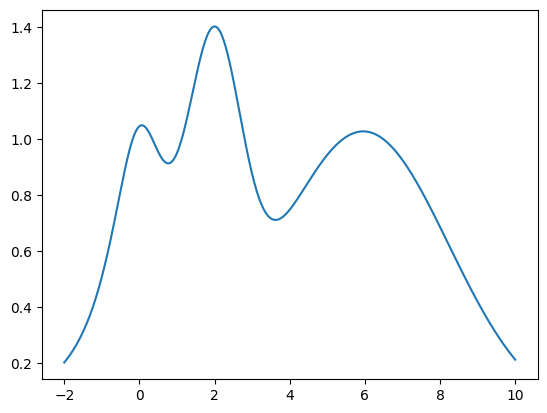

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
from bayes_opt import acquisition

np.random.seed(42)
xs = np.linspace(-2, 10, 10000)

def f(x):
    return np.exp(-(x - 2) ** 2) + np.exp(-(x - 6) ** 2 / 10) + 1/ (x ** 2 + 1)

plt.plot(xs, f(xs))
plt.show()

In [2]:
def plot_bo(f, bo):
    x = np.linspace(-2, 10, 10000)
    mean, sigma = bo._gp.predict(x.reshape(-1, 1), return_std=True)

    plt.figure(figsize=(16, 9))
    plt.plot(x, f(x))
    plt.plot(x, mean)
    plt.fill_between(x, mean + sigma, mean - sigma, alpha=0.1)
    plt.scatter(bo.space.params.flatten(), bo.space.target, c="red", s=50, zorder=10)
    plt.show()

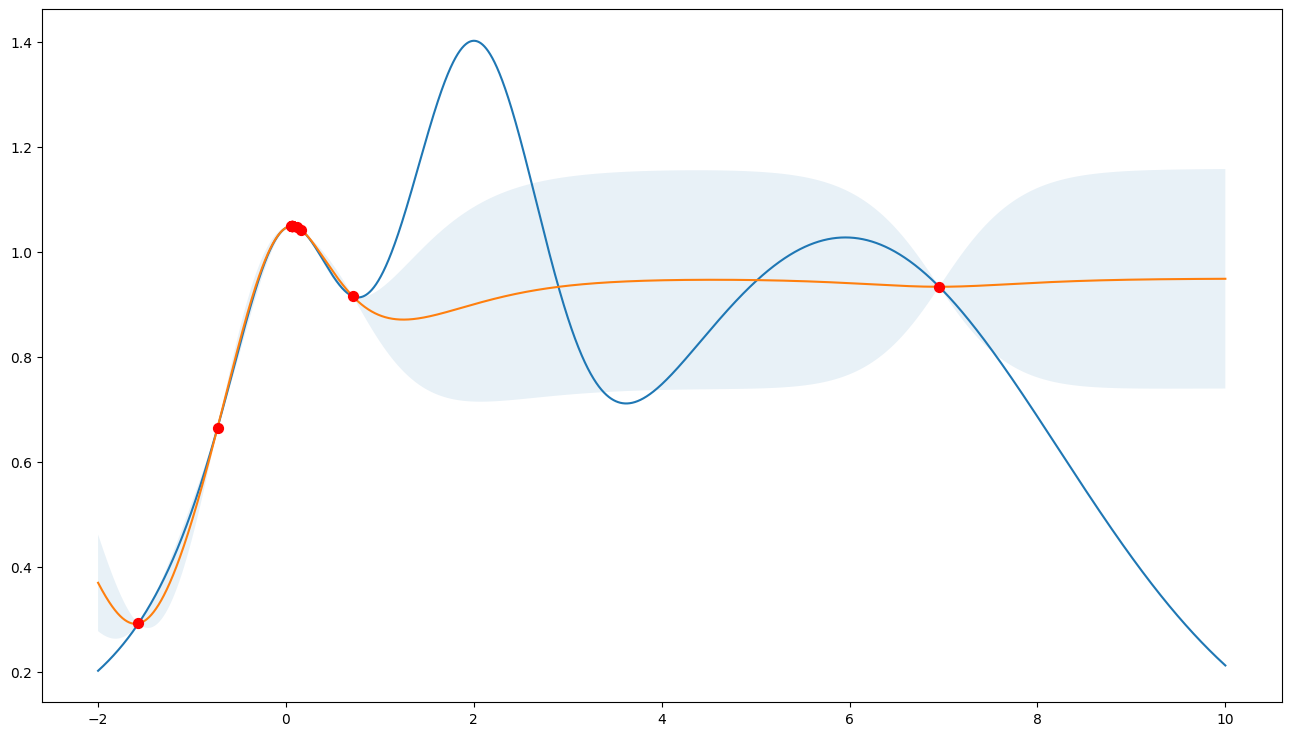

In [3]:
acquisition_function = acquisition.UpperConfidenceBound(kappa=0.1)

bo = BayesianOptimization(
    f=f,
    acquisition_function=acquisition_function,
    pbounds={"x": (-2, 10)},
    verbose=0,
    random_state=987234,
)

bo.maximize(n_iter=10)

plot_bo(f, bo)

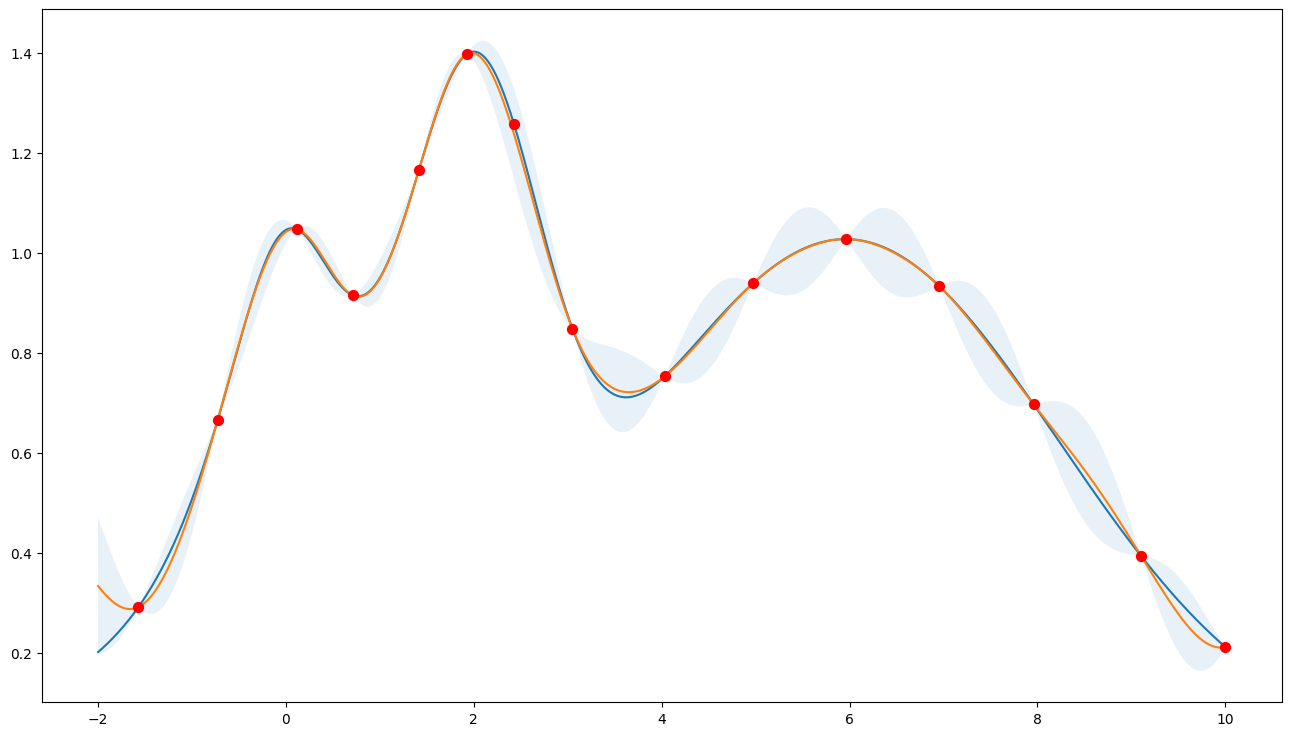

In [4]:
acquisition_function = acquisition.UpperConfidenceBound(kappa=10.)

bo = BayesianOptimization(
    f=f,
    acquisition_function=acquisition_function,
    pbounds={"x": (-2, 10)},
    verbose=0,
    random_state=987234,
)

bo.maximize(n_iter=10)

plot_bo(f, bo)



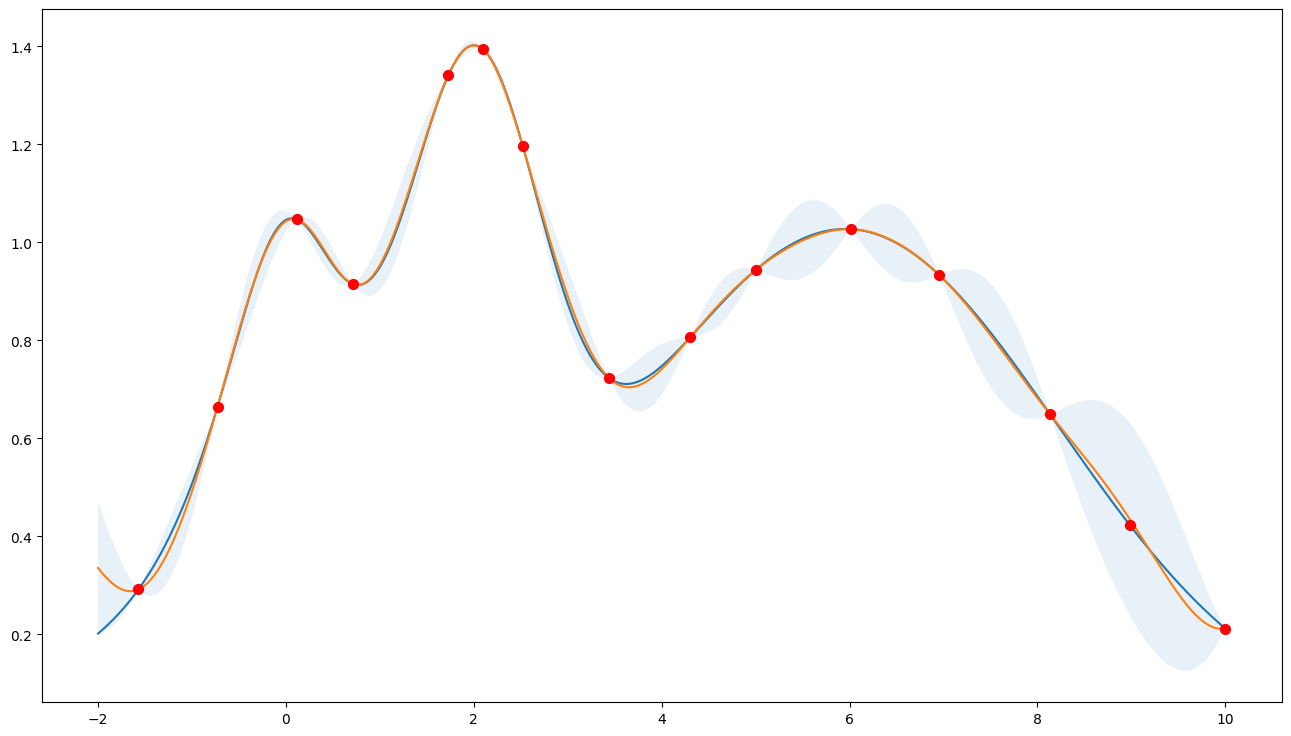

In [5]:
acquisition_function = acquisition.ExpectedImprovement(xi=0.1)

bo = BayesianOptimization(
    f=f,
    acquisition_function=acquisition_function,
    pbounds={"x": (-2, 10)},
    verbose=0,
    random_state=987234,
)

bo.maximize(n_iter=10)

plot_bo(f, bo)

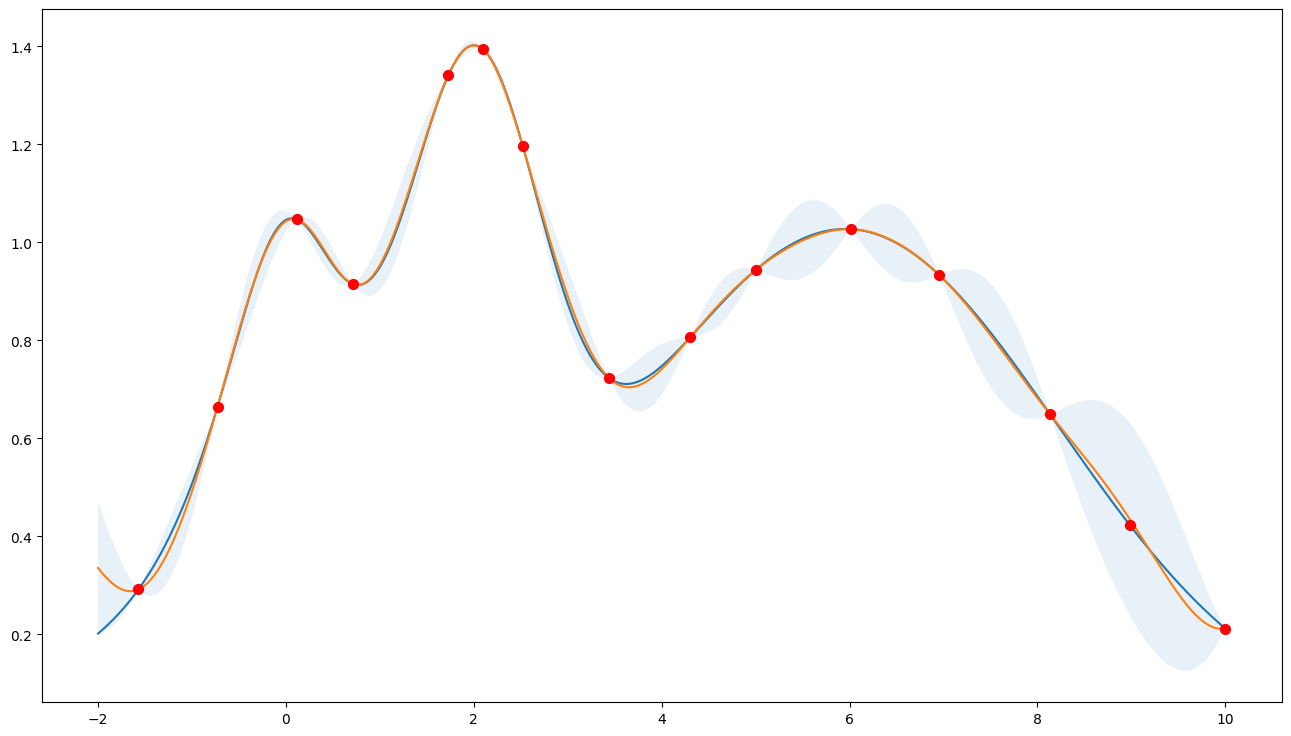

In [7]:
acquisition_function = acquisition.ExpectedImprovement(xi=0.1)

bo = BayesianOptimization(
    f=f,
    acquisition_function=acquisition_function,
    pbounds={"x": (-2, 10)},
    verbose=0,
    random_state=987234,
)

bo.maximize(n_iter=10)

plot_bo(f, bo)

[3.4734996  3.46324329 3.46548555 ... 1.01889801 3.23814255 3.46685498]
[3.47385941]
[3.47385941]
[3.47385941]
[3.47385941]
[3.47385933]
[3.47385933]
[3.47385934]
[3.47385934]
[3.47385946]
[3.47385946]
[3.47385932]
[3.47385932]
[3.47385933]
[3.47385933]
[3.47385946]
[3.47385946]
[3.47385922]
[3.47385922]
[3.47385924]
[3.47385924]
[3.47385946]
[3.47385946]
[3.47385917]
[3.47385917]
[3.47385919]
[3.47385919]
[3.47385946]
[3.47385946]
[3.47385914]
[3.47385914]
[3.47385916]
[3.47385916]
[3.47385946]
[3.47385946]
[3.47385909]
[3.47385909]
[3.47385912]
[3.47385912]
[3.47385946]
[3.47385946]
[3.47385908]
[3.47385908]
[3.47385911]
[3.47385911]
[3.47385946]
[3.47385946]
[3.47385852]
[3.47385852]
[3.47385859]
[3.47385859]
[3.47385946]
[3.47385946]
[3.47385833]
[3.47385833]
[3.47385841]
[3.47385841]
[3.47385946]
[3.47385946]
[3.44155536 3.55327171 2.97731119 ... 1.10285574 3.54003167 2.67666781]
[3.55327415]
[3.55327415]
[3.55327415]
[3.55327415]
[3.55327412]
[3.55327412]
[3.55327413]
[3.55327413

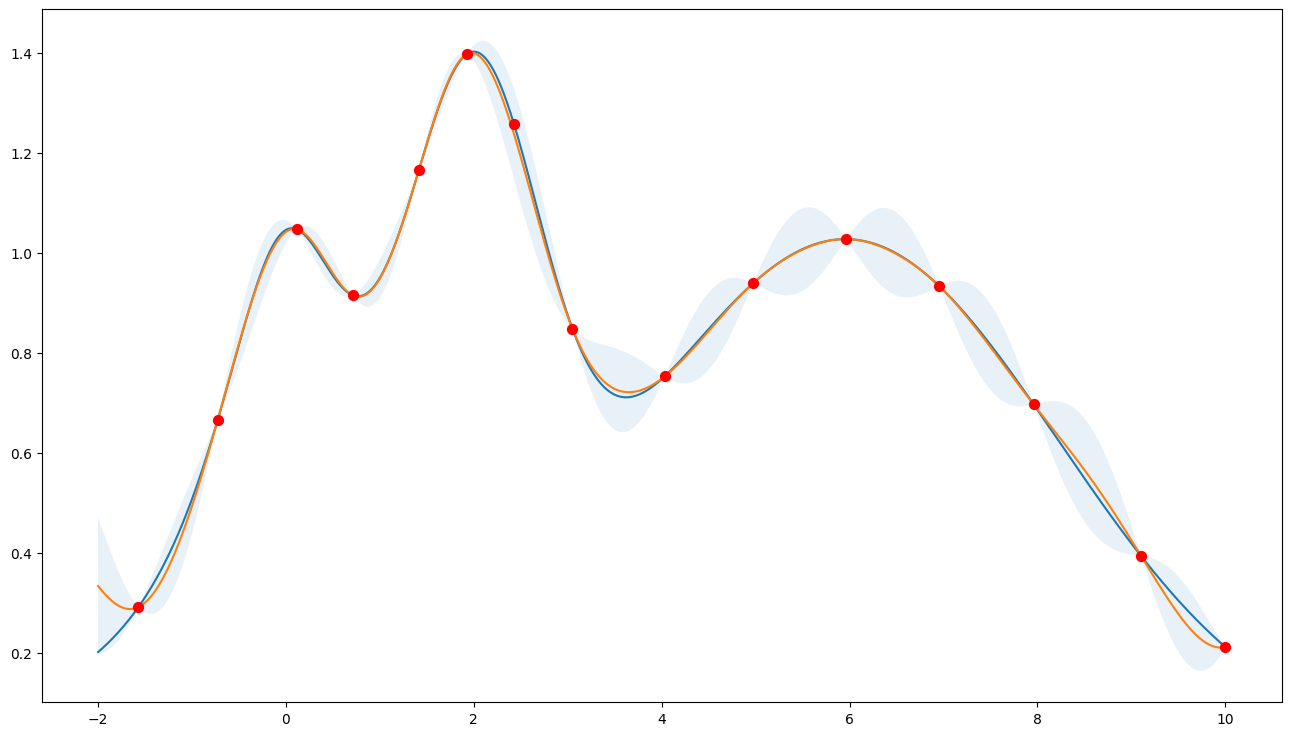

In [14]:
class UpperConfidenceBound(acquisition.AcquisitionFunction):
    def __init__(
        self,
        kappa: float = 2.576,
        exploration_decay= None,
        exploration_decay_delay= None,
        random_state= None,
    ) -> None:
        if kappa < 0:
            error_msg = "kappa must be greater than or equal to 0."
            raise ValueError(error_msg)
        if exploration_decay is not None and not (0 < exploration_decay <= 1):
            error_msg = "exploration_decay must be greater than 0 and less than or equal to 1."
            raise ValueError(error_msg)
        if exploration_decay_delay is not None and (
            not isinstance(exploration_decay_delay, int) or exploration_decay_delay < 0
        ):
            error_msg = "exploration_decay_delay must be an integer greater than or equal to 0."
            raise ValueError(error_msg)

        super().__init__(random_state=random_state)
        self.kappa = kappa
        self.exploration_decay = exploration_decay
        self.exploration_decay_delay = exploration_decay_delay

    def base_acq(self, mean, std):
        acq = mean + self.kappa * std
        print(acq)
        return acq

    def suggest(
        self,
        gp,
        target_space,
        n_random: int = 10_000,
        n_smart: int = 10,
        fit_gp: bool = True,
        random_state = None,
    ) :
        """Suggest a promising point to probe next.

        Parameters
        ----------
        gp : GaussianProcessRegressor
            A fitted Gaussian Process.

        target_space : TargetSpace
            The target space to probe.

        n_random : int, default 10_000
            Number of random samples to use.

        n_smart : int, default 10
            Number of starting points for the L-BFGS-B optimizer.

        fit_gp : bool, default True
            Whether to fit the Gaussian Process to the target space.
            Set to False if the GP is already fitted.

        random_state : int, RandomState, default None
            Random state to use for the optimization.

        Returns
        -------
        np.ndarray
            Suggested point to probe next.
        """
        if target_space.constraint is not None:
            msg = (
                f"Received constraints, but acquisition function {type(self)} "
                "does not support constrained optimization."
            )
            raise ConstraintNotSupportedError(msg)
        x_max = super().suggest(
            gp=gp,
            target_space=target_space,
            n_random=n_random,
            n_smart=n_smart,
            fit_gp=fit_gp,
            random_state=random_state,
        )
        self.decay_exploration()
        return x_max

    def decay_exploration(self) -> None:
        """Decay kappa by a constant rate.

        Adjust exploration/exploitation trade-off by reducing kappa.

        Note
        ----

        This method is called automatically at the end of each ``suggest()`` call.
        """
        if self.exploration_decay is not None and (
            self.exploration_decay_delay is None or self.exploration_decay_delay <= self.i
        ):
            self.kappa = self.kappa * self.exploration_decay

    def get_acquisition_params(self) -> dict:
        """Get the current acquisition function parameters.

        Returns
        -------
        dict
            Dictionary containing the current acquisition function parameters.
        """
        return {
            "kappa": self.kappa,
            "exploration_decay": self.exploration_decay,
            "exploration_decay_delay": self.exploration_decay_delay,
        }

    def set_acquisition_params(self, params: dict) -> None:
        """Set the acquisition function parameters.

        Parameters
        ----------
        params : dict
            Dictionary containing the acquisition function parameters.
        """
        self.kappa = params["kappa"]
        self.exploration_decay = params["exploration_decay"]
        self.exploration_decay_delay = params["exploration_decay_delay"]

acquisition_function = UpperConfidenceBound(kappa=10.)

bo = BayesianOptimization(
    f=f,
    acquisition_function=acquisition_function,
    pbounds={"x": (-2, 10)},
    verbose=0,
    random_state=987234,
)

bo.maximize(n_iter=10)

plot_bo(f, bo)

